In [1]:
import pandas as pd 
!pip install xlrd
import numpy as np
from numpy import arange
import plotnine
from plotnine import *
import seaborn as sns
from scipy import stats
import os
import re
%matplotlib inline 
import matplotlib.pyplot as plt

!pip install geopy
from geopy.geocoders import Nominatim
import matplotlib.ticker as mtick
from matplotlib.ticker import ScalarFormatter

# Data Cleaning
- Remove uninterested columns
- Remove NA values
- Convert variable types

In [3]:
# read housing data
housing = pd.read_csv('/Users/Chuyuan/Desktop/PPOL565 Final Project cz363/DC_Properties.csv', low_memory=False)

# view the data
housing.head()

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,...,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,...,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
1,1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,...,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
2,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,...,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
3,3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,...,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
4,4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,...,-77.039361,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW


In [4]:
# check the dimenstionality of dataset
housing.shape

(158957, 49)

In [5]:
# get the head of data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158957 entries, 0 to 158956
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          158957 non-null  int64  
 1   BATHRM              158957 non-null  int64  
 2   HF_BATHRM           158957 non-null  int64  
 3   HEAT                158957 non-null  object 
 4   AC                  158957 non-null  object 
 5   NUM_UNITS           106696 non-null  float64
 6   ROOMS               158957 non-null  int64  
 7   BEDRM               158957 non-null  int64  
 8   AYB                 158686 non-null  float64
 9   YR_RMDL             80928 non-null   float64
 10  EYB                 158957 non-null  int64  
 11  STORIES             106652 non-null  float64
 12  SALEDATE            132187 non-null  object 
 13  PRICE               98216 non-null   float64
 14  QUALIFIED           158957 non-null  object 
 15  SALE_NUM            158957 non-nul

In [6]:
# convert the type of SQUARE, STORIES to int 
housing['SQUARE'] = housing['SQUARE'].apply(lambda x: int(x.strip()) if str(x).isdigit() else 0)

In [7]:
# drop unnecessary columns and NAs
cols_to_drop = ['NUM_UNITS', 'YR_RMDL', 'FULLADDRESS', 'ASSESSMENT_NBHD', 'Unnamed: 0','NATIONALGRID', 'BLDG_NUM', 'CITY', 'STATE', 'ZIPCODE', 'GRADE', 'STORIES', 'USECODE', 'CMPLX_NUM', 'LIVING_GBA', 'ASSESSMENT_SUBNBHD', 'SOURCE', 'CENSUS_TRACT','CENSUS_BLOCK', 'GIS_LAST_MOD_DTTM', 'QUADRANT', 'X', 'Y']
housing = housing.drop(cols_to_drop, axis=1)
housing = housing.dropna()

# check the dimensionality of the dataset
housing.shape

(57803, 26)

In [8]:
# convert saledate to datetime
housing['SALEDATE'] = pd.to_datetime(housing['SALEDATE'])

# filter time range from 2000-01 to 2018-12
start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2018-12-31')
housing = housing[(housing['SALEDATE'] >= start_date) & (housing['SALEDATE'] <= end_date)]

# format SLAEDATE to year only
housing['SALEDATE'] = housing['SALEDATE'].dt.year

# convert two variables to dummies
housing['AC'] = housing['AC'].map({'0': 0, 'Y': 1, 'N': 0})
housing['QUALIFIED'].replace({'Q': 1, 'U': 0}, inplace=True)

# Data Merging
- Clean and merge housing data with income and race data
- Refine the dataset by removing any rows with missing values
- Fill in missing race data for 2000 by assigning values from 2001-2009, ensuring consistency for each ward over time
- Remove values with a frequency of less than 500

In [9]:
# read unemployment, income and race data
income_original = pd.read_excel('/Users/Chuyuan/Desktop/PPOL565 Final Project cz363/Median income of families with children by ward.xlsx', engine='openpyxl')
race = pd.read_excel('/Users/Chuyuan/Desktop/PPOL565 Final Project cz363/Race_ethnicity of total population by ward.xlsx', engine='openpyxl')

In [10]:
# clean income data
income_original['Data'] = income_original['Data'].str.replace(r'\D+', '', regex=True)
income_original = income_original.drop(['LocationType', 'DataFormat'], axis = 1)
income_original = income_original[income_original.Location != 'District of Columbia']
income1 = income_original.rename({'Data': 'income($)', 'TimeFrame': 'SALEDATE', 'Location':'WARD'}, axis=1)

In [11]:
# locate ward income in 2000, we need this to merge income in housing in 2000-2009
income_2000 = income1[income1['SALEDATE'] == 2000]

In [12]:
# merge income data with housing 2010-2020
new_df1 = pd.merge(housing, income1, on=['WARD', 'SALEDATE'], how='left')

In [13]:
# merge income data with housing 2000-2009
merged_df = pd.merge(new_df1[['WARD']], income_2000[['WARD', 'income($)']], on='WARD', how='left')
new_df1['income($)'] = new_df1['income($)'].fillna(merged_df['income($)'])

In [14]:
new_df1.head()

,BATHRM,HF_BATHRM,HEAT,AC,ROOMS,BEDRM,AYB,EYB,SALEDATE,PRICE,...,ROOF,INTWALL,KITCHENS,FIREPLACES,LANDAREA,LATITUDE,LONGITUDE,WARD,SQUARE,income($)
0,4,0,Warm Cool,1,8,4,1910.0,1972,2003,1095000.0,...,Metal- Sms,Hardwood,2.0,5,1680,38.914680,-77.040832,Ward 2,152,47300
1,3,1,Hot Water Rad,1,9,5,1910.0,1984,2016,2100000.0,...,Built Up,Hardwood,2.0,4,1680,38.914684,-77.040678,Ward 2,152,182019
2,3,1,Hot Water Rad,1,8,5,1900.0,1984,2006,1602000.0,...,Built Up,Hardwood,2.0,3,1680,38.914683,-77.040629,Ward 2,152,47300
3,3,2,Hot Water Rad,1,10,5,1913.0,1972,2010,1950000.0,...,Built Up,Hardwood,1.0,4,2196,38.914331,-77.039715,Ward 2,152,105600
4,3,1,Hot Water Rad,1,8,4,1906.0,1972,2011,1050000.0,...,Metal- Sms,Hardwood,2.0,1,1627,38.915408,-77.040129,Ward 2,152,116477


In [15]:
# clean race data 
race = race.loc[(race.Location != 'District of Columbia') & (race['DataFormat'] != 'Number') &          
                (race['Race Ethnicity'].isin(['Asian', 'White', 'Black', 'Hispanic']))]

race = race.drop(['LocationType', 'Age group', 'DataFormat'], axis = 1)
race1 = race.rename({'Data': 'race_prop', 'TimeFrame': 'SALEDATE', 'Location':'WARD'}, axis=1)

In [16]:
# convert long format to wide format
race1 = race1.pivot(index=['WARD', 'SALEDATE'], columns='Race Ethnicity', values='race_prop')
race1 = race1.reset_index().rename_axis(None, axis=1)

# merge race data with housing
df = pd.merge(new_df1, race1, on=['WARD', 'SALEDATE'], how='left')

In [17]:
# locate race in in year 2000
race_2000 = race1[race1['SALEDATE'] == 2000]

# create a list of columns to fill
columns_to_fill = ['Asian', 'Black', 'White', 'Hispanic']

# loop through the columns and fill missing values
for col in columns_to_fill:
    df[col].fillna(df['WARD'].map(race_2000.set_index('WARD')[col]), inplace=True)


# round proportion values
df = df.round({'Asian': 2, 'Black':2, 'Hispanic':2, 'White':2})

# convert income type
df['income($)'] = df['income($)'].astype(int)
df.shape

(50983, 31)

In [18]:
# check NA values
df.isna().sum()

BATHRM        0
HF_BATHRM     0
HEAT          0
AC            0
ROOMS         0
BEDRM         0
AYB           0
EYB           0
SALEDATE      0
PRICE         0
QUALIFIED     0
SALE_NUM      0
GBA           0
STYLE         0
STRUCT        0
CNDTN         0
EXTWALL       0
ROOF          0
INTWALL       0
KITCHENS      0
FIREPLACES    0
LANDAREA      0
LATITUDE      0
LONGITUDE     0
WARD          0
SQUARE        0
income($)     0
Asian         0
Black         0
Hispanic      0
White         0
dtype: int64

In [19]:
# remove the frequency of values less than 500
v = df[['HEAT', 'STYLE', 'STRUCT', 'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'WARD']]
df=df[v.replace(v.apply(pd.Series.value_counts)).gt(500).all(1)]

In [20]:
# summary continuous variable 
numeric_info = df.describe()
rounded_numeric_info = numeric_info.T
rounded_numeric_info['median'] = rounded_numeric_info.median(axis = 1)
rounded_numeric_info.round(2)

,count,mean,std,min,25%,50%,75%,max,median
BATHRM,44695.0,2.21,1.04,0.00,1.00,2.00,3.00,11.00,2.10
HF_BATHRM,44695.0,0.64,0.60,0.00,0.00,1.00,1.00,7.00,0.82
AC,44695.0,0.75,0.43,0.00,1.00,1.00,1.00,1.00,1.00
ROOMS,44695.0,7.39,2.28,0.00,6.00,7.00,8.00,31.00,7.20
BEDRM,44695.0,3.41,1.10,0.00,3.00,3.00,4.00,20.00,3.21
AYB,44695.0,1933.63,30.02,1776.00,1912.00,1928.00,1946.00,2018.00,1930.81
EYB,44695.0,1970.01,16.23,1933.00,1960.00,1967.00,1974.00,2018.00,1968.50
SALEDATE,44695.0,2010.61,5.46,2000.00,2006.00,2012.00,2015.00,2018.00,2011.30
PRICE,44695.0,607203.99,578903.03,1.00,280000.00,490000.00,775000.00,25100000.00,534451.52
QUALIFIED,44695.0,0.81,0.39,0.00,1.00,1.00,1.00,1.00,1.00


# Data Visualization


### Housing Market Trend in DC

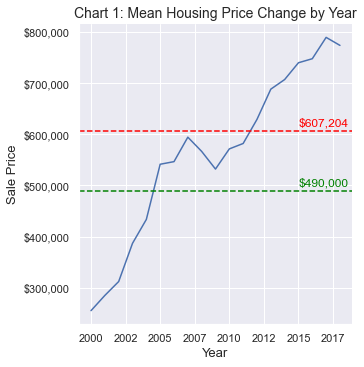

<Figure size 432x288 with 0 Axes>

In [21]:
sns.set_palette("Set2")
sns.set(style='darkgrid', font_scale=1)

# calculate mean price by date
df_mean_price = df.groupby('SALEDATE')['PRICE'].mean().reset_index()

# calculate mean and median price across all sales
mean_price = df['PRICE'].mean()
median_price = df['PRICE'].median()

# Create the plot
g = sns.relplot(data=df_mean_price, x="SALEDATE", y="PRICE", kind="line", hue=None)

# Add the horizontal line for the mean price
plt.axhline(y=mean_price, color='red', linestyle='--')
plt.text(2015, mean_price + 10000, "${:,.0f}".format(mean_price), color='red')
plt.axhline(y=median_price, color='green', linestyle='--')
plt.text(2015, median_price + 10000, "${:,.0f}".format(median_price), color='green')

# Define a function to format the y-tick labels
def format_yticks(y, pos):
    return "${:,.0f}".format(y)

# Apply the formatter to the y-axis
g.ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_yticks))

# Define a function to format the x-tick labels as integers
def format_xticks(x, pos):
    return int(x)

# Apply the formatter to the x-axis
g.ax.xaxis.set_major_formatter(mtick.FuncFormatter(format_xticks))

plt.xlabel('Year', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Chart 1: Mean Housing Price Change by Year', fontsize=14)
# Show the plot
plt.show()

plt.savefig('ovreall price change')

### Housing Price Change Accross Wards by Years

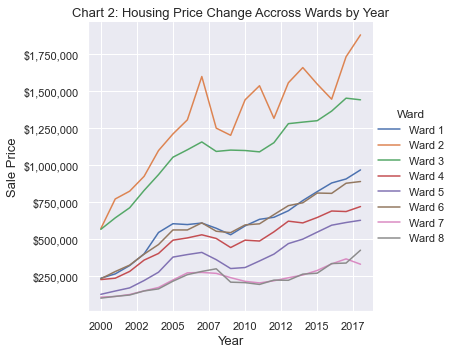

In [22]:
df_mean_price = df.groupby(['SALEDATE','WARD'])['PRICE'].mean().reset_index()

g = sns.relplot(data=df_mean_price, x="SALEDATE", y="PRICE", hue="WARD", kind="line")


# Set the legend title and fontsize
g._legend.set_title("Ward")

# Define a function to format the y-tick labels
def format_yticks(y, pos):
    return "${:,.0f}".format(y)

# Apply the formatter to the y-axis
g.ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_yticks))

# Define a function to format the x-tick labels as integers
def format_xticks(x, pos):
    return int(x)

# Apply the formatter to the x-axis
g.ax.xaxis.set_major_formatter(mtick.FuncFormatter(format_xticks))


plt.xlabel('Year', fontsize=13)
plt.ylabel('Sale Price', fontsize=13)
plt.title('Chart 2: Housing Price Change Accross Wards by Year', fontsize=13)

# Show the plot


plt.savefig('Ward.png', bbox_inches="tight")

plt.show()

### Distribution of Sold Home Across Wards accross in DC

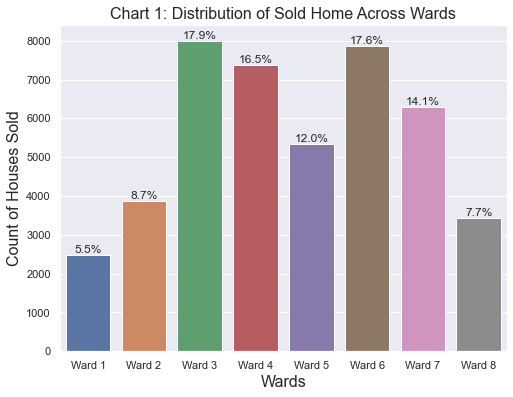

In [23]:
plt.figure(figsize=(8,6))

ax = sns.countplot(x='WARD', data=df)

plt.title('Chart 1: Distribution of Sold Home Across Wards', fontsize=16)
plt.xlabel('Wards', fontsize=16)
plt.ylabel('Count of Houses Sold', fontsize=16)

ax.set_xticklabels(['Ward {}'.format(i) for i in range(1, 9)])

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/len(df)), (x.mean(), y), ha='center', va='bottom')

plt.savefig('Distribution of Wards')
plt.show()

### Distribution of Building Characteristics

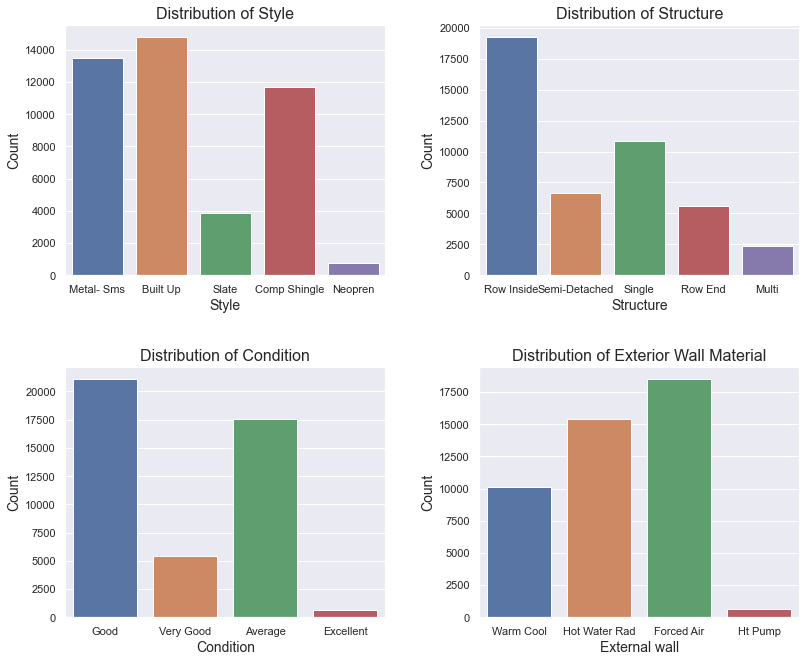

In [24]:
# create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# plot the first variable
sns.countplot(x='ROOF', data=df, ax=axs[0, 0])
axs[0, 0].set_xlabel('Style', fontsize=14)
axs[0, 0].set_ylabel('Count', fontsize=14)
axs[0, 0].set_title('Distribution of Style',fontsize=16)

# plot the second variable
sns.countplot(x='STRUCT', data=df, ax=axs[0, 1])
axs[0, 1].set_xlabel('Structure', fontsize=14)
axs[0, 1].set_ylabel('Count', fontsize=14)
axs[0, 1].set_title('Distribution of Structure',fontsize=16)

# plot the third variable
sns.countplot(x='CNDTN', data=df, ax=axs[1, 0])
axs[1, 0].set_xlabel('Condition', fontsize=14)
axs[1, 0].set_ylabel('Count', fontsize=14)
axs[1, 0].set_title('Distribution of Condition', fontsize=16)

# plot the fourth variable
sns.countplot(x='HEAT', data=df, ax=axs[1, 1])
axs[1, 1].set_xlabel('External wall', fontsize=14)
axs[1, 1].set_ylabel('Count', fontsize=14)
axs[1, 1].set_title('Distribution of Exterior Wall Material',fontsize=16)

# adjust subplot spacing
fig.tight_layout(pad=3.0)

plt.savefig('four')

### Race Distribution in Sold Home in DC

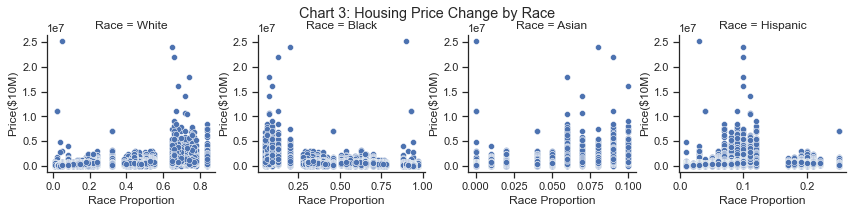

In [25]:
sns.set(style="ticks")

# Melt the dataframe to a long format
df_long = df.melt(id_vars=['PRICE'], value_vars=['White', 'Black', 'Asian', 'Hispanic'], var_name='Race')

g = sns.FacetGrid(df_long, col='Race', sharey = False, sharex = False)#, col_wrap=2, height=4)
g = g.map(sns.scatterplot, 'value', 'PRICE')

for ax in g.axes.flat:
    _ = ax.set_xlabel('Race Proportion')
    _ = ax.set_ylabel('Price($10M)')
    
g.fig.suptitle('Chart 3: Housing Price Change by Race')

# Adjust plot layout
plt.subplots_adjust(top=0.85)

plt.savefig('RACE.png')
plt.show()

### Check Features Correlation and Feature Engineering

In [26]:
# AYB -- building age
df["building_age"] = df['SALEDATE']-df["AYB"]

# EYB -- years from its last improvement
df["Year_after_improved"] = df['SALEDATE']-df["EYB"]

# BATHRM -- add full bathroom and half-bathroom together
df['BATHRM_TOTAL'] = df['BATHRM'] + df['HF_BATHRM']*0.5

# Generate dataset for prediction
df1 = df.drop(['LATITUDE','LONGITUDE','SALE_NUM','SALEDATE', 'BATHRM','AYB','EYB','HF_BATHRM'], axis = 1)

In [27]:
df1.head()

,HEAT,AC,ROOMS,BEDRM,PRICE,QUALIFIED,GBA,STYLE,STRUCT,CNDTN,...,WARD,SQUARE,income($),Asian,Black,Hispanic,White,building_age,Year_after_improved,BATHRM_TOTAL
0,Warm Cool,1,8,4,1095000.0,1,2522.0,3 Story,Row Inside,Good,...,Ward 2,152,47300,0.08,0.20,0.10,0.65,93.0,31,4.0
1,Hot Water Rad,1,9,5,2100000.0,1,2522.0,3 Story,Row Inside,Very Good,...,Ward 2,152,182019,0.09,0.09,0.11,0.67,106.0,32,3.5
2,Hot Water Rad,1,8,5,1602000.0,1,2484.0,3 Story,Row Inside,Good,...,Ward 2,152,47300,0.08,0.20,0.10,0.65,106.0,22,3.5
4,Hot Water Rad,1,8,4,1050000.0,1,2401.0,3 Story,Row Inside,Average,...,Ward 2,152,116477,0.09,0.13,0.10,0.66,105.0,39,3.5
5,Warm Cool,1,7,3,1430000.0,1,1488.0,2 Story,Row Inside,Very Good,...,Ward 2,152,198594,0.10,0.09,0.12,0.66,110.0,51,3.5


In [28]:
df1.shape

(44695, 26)

In [29]:
# check correlation between price and variables
corr_matrix = df1.corr()
corr_matrix["PRICE"].sort_values(ascending=False)

PRICE                  1.000000
GBA                    0.613407
Asian                  0.574141
White                  0.542745
income($)              0.527751
BATHRM_TOTAL           0.527398
FIREPLACES             0.509457
LANDAREA               0.404099
BEDRM                  0.357114
ROOMS                  0.331970
AC                     0.204429
Hispanic               0.200329
building_age           0.170855
QUALIFIED              0.161706
KITCHENS               0.044082
Year_after_improved   -0.192829
SQUARE                -0.418723
Black                 -0.563001
Name: PRICE, dtype: float64

Text(0.5, 1.0, 'Correlation matrix of variables')

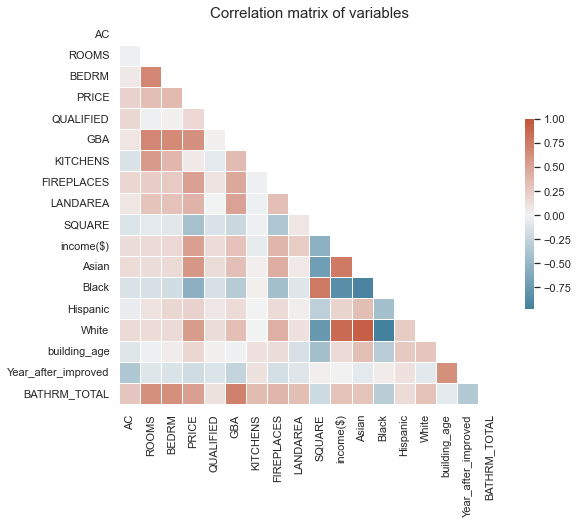

In [30]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df1.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title("Correlation matrix of variables", fontsize = 15)

# Prediction
The prediction of housing prices include LASSO, decision tree, random forest and XGBoost model.

In [31]:
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, validation_curve, RandomizedSearchCV, GridSearchCV, train_test_split, RepeatedKFold
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, Lasso, LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import plot_importance

### Create dummies and Scaling

In [32]:
# get dummies for categorical variables
cat_cols = ['HEAT', 'STYLE','STRUCT','CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'WARD']

for col in cat_cols:
    dummies = pd.get_dummies(df1[col], drop_first = True)
    df1[dummies.columns] = dummies
    df1.drop(col, axis=1, inplace=True)

# remove outliers
df2=df1[(np.abs(stats.zscore(df1)) < 6).all(axis=1)]

In [33]:
# apply log transformation to target variable
df2 = df2.assign(Price_log=np.log(df2['PRICE']))
df2 = df2.drop(['PRICE'], axis=1)
# Select the numeric columns
numeric_cols = ['ROOMS', 'BEDRM', 'BATHRM_TOTAL', 'KITCHENS', 'FIREPLACES', 'Year_after_improved', 'LANDAREA', 'building_age', 'SQUARE', 
                'income($)', 'Hispanic', 'White', 'Asian', 'Black']

In [34]:
# Create a StandardScaler object
scaler = StandardScaler()

# Scale the numeric columns in place
df2[numeric_cols] = scaler.fit_transform(df2[numeric_cols])

In [35]:
# create feature matrix and target array
y = df2['Price_log']
X = df2.drop(['Price_log'], axis = 1)

In [36]:
X.head()

,AC,ROOMS,BEDRM,QUALIFIED,GBA,KITCHENS,FIREPLACES,LANDAREA,SQUARE,income($),...,Hardwood,Hardwood/Carp,Wood Floor,Ward 2,Ward 3,Ward 4,Ward 5,Ward 6,Ward 7,Ward 8
0,1,0.293541,0.572291,1,2522.0,1.120023,5.391131,-0.537122,-1.682667,-0.604598,...,1,0,0,1,0,0,0,0,0,0
1,1,0.743578,1.508515,1,2522.0,1.120023,4.173095,-0.537122,-1.682667,1.675537,...,1,0,0,1,0,0,0,0,0,0
2,1,0.293541,1.508515,1,2484.0,1.120023,2.955059,-0.537122,-1.682667,-0.604598,...,1,0,0,1,0,0,0,0,0,0
4,1,0.293541,0.572291,1,2401.0,1.120023,0.518987,-0.561596,-1.682667,0.566231,...,1,0,0,1,0,0,0,0,0,0
5,1,-0.156495,-0.363934,1,1488.0,1.120023,0.518987,-0.655333,-1.682667,1.956071,...,1,0,0,1,0,0,0,0,0,0


In [37]:
X.shape

(41649, 49)

### Parametric model
### Lasso

In [38]:
# Create evaluation function
def performance(model, Xtest, ytest):
    predict = model.predict(Xtest)
    print('MAE:', metrics.mean_absolute_error(ytest, predict))
    print('MSE:', metrics.mean_squared_error(ytest, predict))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, predict)))
    print( 'R2', r2_score(ytest, predict))

In [39]:
# Split the data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state = 0)

# Fit Lasso regression
lasso = Lasso()
lasso.fit(Xtrain, ytrain)
performance(lasso, Xtest, ytest)

MAE: 0.5295427254196005
MSE: 0.451016956370987
RMSE: 0.6715779600098465
R2 0.21939879452902888


In [40]:
# Create a LassoCV object with the list of alpha values to search
lasso_cv = LassoCV(alphas=[0.005, 0.01, 0.1, 0.5], cv=6)

# Fit the model to the data
lasso_cv.fit(Xtrain, ytrain)

# Print the optimal alpha value
print('Optimal alpha:', lasso_cv.alpha_)

Optimal alpha: 0.005


In [41]:
# Fit the best Lasso model
Lasso = Lasso(alpha=lasso_cv.alpha_)
Lasso.fit(Xtrain, ytrain)

# Evaluate Lasso model with optimal alpha value
performance(Lasso, Xtest, ytest)

MAE: 0.2783346685027264
MSE: 0.16080777323994525
RMSE: 0.40100844534740815
R2 0.7216806599684669


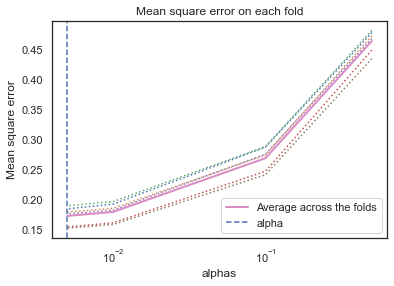

In [42]:
# Plot mean square error
fig, ax = plt.subplots(figsize=(6,4))
ax.semilogx(lasso_cv.alphas_, lasso_cv.mse_path_, ":")
ax.plot(
    lasso_cv.alphas_ ,
    lasso_cv.mse_path_.mean(axis=-1),
    label="Average across the folds",
    linewidth=2,
)
ax.axvline(
    lasso_cv.alpha_, linestyle="--", label="alpha"
)
ax.set_xlabel("alphas")
ax.set_ylabel("Mean square error")
ax.set_title("Mean square error on each fold")
ax.legend()
fig.savefig('mse_plot.png', bbox_inches='tight')
plt.show()

In [43]:
df_compare = pd.DataFrame({'Variable': X.columns, 'Lasso Coef(alpha = 0.005)': Lasso.coef_})
df_compare = df_compare.sort_values(by='Lasso Coef(alpha = 0.005)', ascending=False)
df_compare.head(15)

,Variable,Lasso Coef(alpha = 0.005)
30,Very Good,0.336242
3,QUALIFIED,0.313459
29,Good,0.168747
9,income($),0.146721
16,BATHRM_TOTAL,0.115195
0,AC,0.082038
14,building_age,0.080473
45,Ward 5,0.068347
6,FIREPLACES,0.058750
7,LANDAREA,0.033090


### Non-parametric model
### Decision Tree

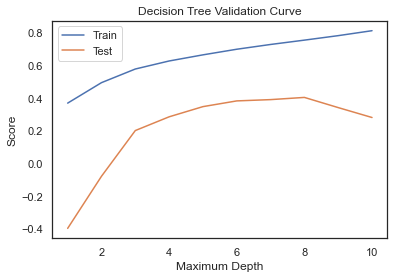

In [44]:
# Fit the model
DT = DecisionTreeRegressor(random_state = 20)
param_range = np.arange(1,11)
train_scores, test_scores = validation_curve(DT, X, y, param_name='max_depth', param_range=param_range, cv=6)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

fig1 = plt.figure()
plt.plot(param_range, train_mean, label='Train')
plt.plot(param_range, test_mean, label='Test')
plt.xlabel('Maximum Depth')
plt.ylabel('Score')
plt.title('Decision Tree Validation Curve')
plt.legend()
plt.savefig('DTVC.png')
plt.show()

In [45]:
# Fit decision tree with max_depth = 7
tree = DecisionTreeRegressor(max_depth = 7, random_state = 20)
tree.fit(Xtrain, ytrain)

# Evaluate Decision tree performance
performance(tree, Xtest, ytest)

MAE: 0.28245986408204565
MSE: 0.1668061920445419
RMSE: 0.4084191377060359
R2 0.711298848633781


### Parameter tuning (Grid Search) -- Decision Tree

In [46]:
# specify the hyperparameter grid to search over
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
    'max_leaf_nodes': [5, 10, 20, 30, 40, 50]
}

# create the grid search object
grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(),
    param_grid=param_grid,
    cv=6,  # number of cross-validation folds to use
    scoring='neg_mean_squared_error',  # metric to optimize
    n_jobs=-1  # number of CPU cores to use in parallel (-1 means all available cores)
)

# fit the grid search object to the data
grid_search.fit(Xtrain, ytrain)

# print the best hyperparameters found by the grid search
print(grid_search.best_params_)

{'max_depth': 10, 'max_leaf_nodes': 50, 'min_samples_leaf': 7}


In [47]:
# Evaluate the performance
best_model = grid_search.best_estimator_
performance(best_model, Xtest, ytest)

MAE: 0.2901985377671137
MSE: 0.17021990737140694
RMSE: 0.41257715323489125
R2 0.7053905335213583


In [48]:
# Cross validation score
scores = cross_val_score(best_model, X, y, cv=6, scoring='neg_mean_squared_error')

# Print the scores and their mean
print('Cross-validation scores:', -scores)
print('Mean score:', -scores.mean())

Cross-validation scores: [0.2322707  0.16567164 0.24642676 0.17909413 0.27080039 0.23583717]
Mean score: 0.2216834657969373


### Random Forest

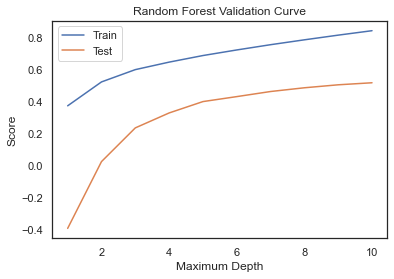

In [49]:
# Fit the random forest model
RF = RandomForestRegressor(random_state = 20)
param_range = np.arange(1,11)
train_scores, test_scores = validation_curve(RF, X, y, param_name='max_depth', param_range=param_range, cv=6)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

fig1 = plt.figure()
plt.plot(param_range, train_mean, label='Train')
plt.plot(param_range, test_mean, label='Test')
plt.xlabel('Maximum Depth')
plt.ylabel('Score')
plt.title('Random Forest Validation Curve')
plt.legend()
plt.savefig('RFVC.png')
plt.show()

In [50]:
# fit random forest model
RF.fit(Xtrain, ytrain)

# Evaluate the performance
performance(RF, Xtest, ytest)

MAE: 0.21893595855262263
MSE: 0.1252086660096176
RMSE: 0.35384836584279655
R2 0.7832940996078102


In [51]:
# Fit random forest model with max_depth =8
rf = RandomForestRegressor(max_depth=8, random_state = 20)
rf.fit(Xtrain, ytrain)

# Evaluate the performance
performance(rf, Xtest, ytest)

MAE: 0.2557474062529419
MSE: 0.14400478459738575
RMSE: 0.37947962342843355
R2 0.7507625669890712


In [52]:
# Cross validation score
scores = cross_val_score(rf, X, y, cv=6, scoring='neg_mean_squared_error')

# Print the scores and their mean
print('Cross-validation scores:', -scores)
print('Mean score:', -scores.mean())

Cross-validation scores: [0.19495917 0.13812494 0.19201353 0.14737301 0.23222673 0.19950516]
Mean score: 0.1840337569838544


### XGBoost

In [53]:
xgbr = xgb.XGBRegressor(random_state = 10)

# Fit the regressor to the training set
xgbr.fit(Xtrain, ytrain)

# Evaluate the performance of XGBoost
performance(xgbr, Xtest, ytest)

MAE: 0.2140149562262604
MSE: 0.11661518802800616
RMSE: 0.341489660206581
R2 0.7981673303741417


In [54]:
scores = cross_val_score(xgbr, X, y, cv=6, scoring='neg_mean_squared_error')

# Print the scores and their mean
print('Cross-validation scores:', -scores)
print('Mean score:', -scores.mean())

Cross-validation scores: [0.23544094 0.13793195 0.14546632 0.12011553 0.221141   0.23456937]
Mean score: 0.18244418582234015


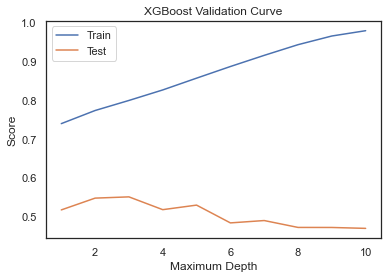

In [55]:
# Fit XGBoost model
xgbr = xgb.XGBRegressor(random_state = 20) 
param_range = np.arange(1,11)
train_scores, test_scores = validation_curve(xgbr, X, y, param_name='max_depth', param_range=param_range, cv=6)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

fig1 = plt.figure()
plt.plot(param_range, train_mean, label='Train')
plt.plot(param_range, test_mean, label='Test')
plt.xlabel('Maximum Depth')
plt.ylabel('Score')
plt.title('XGBoost Validation Curve')
plt.legend()
plt.show()

### Parameter tuning (Grid Search) -- XGBoost

In [56]:
gbm_param_grid = {
    'colsample_bytree': [0.3, 0.8],
    'n_estimators': [50, 100, 200],
    'max_depth': [2,3,4,5]
}


# Perform grid search: grid_mse
grid_mse = GridSearchCV(estimator = xgbr, param_grid = gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 6, verbose = 1)


# Fit grid_mse to the data
grid_mse.fit(Xtrain, ytrain)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)

Fitting 6 folds for each of 24 candidates, totalling 144 fits
Best parameters found:  {'colsample_bytree': 0.8, 'max_depth': 4, 'n_estimators': 200}


In [57]:
XGBoost = grid_mse.best_estimator_
performance(XGBoost, Xtest, ytest)

MAE: 0.21200610483743063
MSE: 0.11045952280719432
RMSE: 0.3323545137457807
R2 0.808821297201697


In [58]:
scores = cross_val_score(XGBoost, X, y, cv=6, scoring='neg_mean_squared_error')

# Print the scores and their mean
print('Cross-validation scores:', -scores)
print('Mean score:', -scores.mean())

Cross-validation scores: [0.22289406 0.13636258 0.1506563  0.12889739 0.20327922 0.21693507]
Mean score: 0.17650410200029376


### Feature Importances

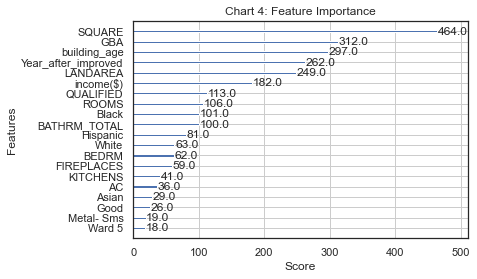

In [59]:
fig, ax = plt.subplots()
plot_importance(XGBoost, max_num_features=20, ax=ax)
ax.set_xlabel('Score')
ax.set_title('Chart 4: Feature Importance')
plt.savefig('importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [60]:
def evaluate_model(model, X, y, cv):
    # Calculate cross validation scores
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')

    # Fit the model and make predictions on the test data
    model.fit(Xtrain, ytrain)
    predict = model.predict(Xtest)
    
    # Calculate evaluation metrics
    mae = metrics.mean_absolute_error(ytest, predict)
    mse = metrics.mean_squared_error(ytest, predict)
    rmse = np.sqrt(mse)
    r2 = r2_score(ytest, predict)
    
    # Create a DataFrame of the evaluation metrics
    results = {
        'Model': [type(model).__name__],
        'MAE': [mae],
        'MSE': [mse],
        'RMSE': [rmse],
        'R2': [r2],
        'Cross Val Score': [np.mean(-scores)]
    }
    df_result = pd.DataFrame(results)

    return df_result


In [61]:
# Define the models to evaluate
models = [Lasso, best_model, rf, XGBoost]

# Evaluate each model and concatenate the results into a single DataFrame
df_results = pd.concat([evaluate_model(model, X, y, cv=6) for model in models])

In [62]:
# Performance after parameter tunning
df_results

,Model,MAE,MSE,RMSE,R2,Cross Val Score
0,Lasso,0.278335,0.160808,0.401008,0.721681,0.181943
0,DecisionTreeRegressor,0.290199,0.170220,0.412577,0.705391,0.221683
0,RandomForestRegressor,0.255747,0.144005,0.379480,0.750763,0.184034
0,XGBRegressor,0.212006,0.110460,0.332355,0.808821,0.176504
